In [21]:
#Setup
import numpy as np
from numpy.testing import assert_almost_equal
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib.pyplot as plt 


## Part 0 - Setup

In [22]:
### Constants
sigma1 = 0.11
sigma2 = 0.13
T = 1.7
sim_end_time = T #This is true in Q1, not later on
mu = 0.13
r = 0.01
S0 = 149
time_break = 0.3
K = 188
KH = S0
n_sims = 5_000 #default value, overwritten later
n_steps = int(T * 365) #Assume time in years, this is daily time-steps

In [23]:
### Helper Functions

### Time-varying vol

def constant_vol(t):
    return sigma1 + sigma2

def time_varying_vol(t):
    if t > time_break:
        return sigma1 + sigma2 * (t - time_break)/(T - time_break)
    return sigma1

assert_almost_equal(np.array([time_varying_vol(0.2), time_varying_vol(0.4), time_varying_vol(0.5), time_varying_vol(T)]) ,
                    np.array([sigma1, 0.11928571428, 0.128571429, sigma1 + sigma2]))

def integrate_vol(start_time = 0, end_time = T):
    squared_vol = lambda x: time_varying_vol(x) ** 2
    result = integrate.quad(squared_vol, start_time, end_time)
    return result[0]

assert_almost_equal(np.array([integrate_vol(end_time = time_break), integrate_vol(0, 1), integrate_vol(start_time = 0)]),
                    np.array([time_break * sigma1 ** 2, 0.018090833333, 0.0484766666]))

### Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2

def black_scholes_call_price(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return S * norm.cdf(d1) - K * np.exp(-r * (T- t)) * norm.cdf(d2)

def black_scholes_put_price(S,t, K,T,r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return  K * np.exp(-r * (T - t)) * norm.cdf( -d2) - S * norm.cdf(-d1) 

def black_scholes_call_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.cdf(d1)

def black_scholes_put_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return -1 * norm.cdf(-1 * d1)

def black_scholes_gamma(S, t, K, T, r,sigma):
    #same for a call and put
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.pdf(d1)/(S * sigma * np.sqrt(T - t))


assert_almost_equal(black_scholes_call_price(100,0,  100, 1, 0.01, 0.2), 8.43332, decimal = 5)
assert_almost_equal(black_scholes_call_price(100,0.99,  95, 1, 0.01, 0.2), 5.01264, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0, 100, 1, 0.01, 0.2), 7.43831, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0.99,  95, 1, 0.01, 0.2), 0.00314, decimal = 5)

assert_almost_equal(black_scholes_call_delta(100,0, 100, 1, 0.01, 0.2), 0.55962, decimal = 5)
assert_almost_equal(black_scholes_call_delta(100,0.99,  95, 1, 0.01, 0.2), 0.99506, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0, 100, 1, 0.01, 0.2), -0.44038, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0.99, 95, 1, 0.01, 0.2), -0.00494, decimal = 5)


assert_almost_equal(black_scholes_gamma(100,0, 100, 1, 0.01, 0.2), 0.01972, decimal = 5)
assert_almost_equal(black_scholes_gamma(100,0.99, 95, 1, 0.01, 0.2), 0.00716, decimal = 5)




In [24]:
class time_varying_vol:
    def __init__(self):
        pass
    
    def time_varying_vol(self, t):
        if t > time_break:
            return sigma1 + sigma2 * (t - time_break)/(T - time_break) # this needs to be the constant T, rather than the input T
        return sigma1

    def integrate_vol(self, start_time, end_time):
        squared_vol = lambda x: self.time_varying_vol(x) ** 2
        result = integrate.quad(squared_vol, start_time, end_time)
        return result[0]

Test_vol = time_varying_vol()
assert_almost_equal(np.array([Test_vol.time_varying_vol(0.2), Test_vol.time_varying_vol(0.4), Test_vol.time_varying_vol(0.5), Test_vol.time_varying_vol(T)]) ,
                    np.array([sigma1, 0.11928571428, 0.128571429, sigma1 + sigma2]))

assert_almost_equal(np.array([Test_vol.integrate_vol(start_time = 0, end_time = time_break), Test_vol.integrate_vol(0, 1), Test_vol.integrate_vol(start_time = 0, end_time = T)]),
                    np.array([time_break * sigma1 ** 2, 0.018090833333, 0.0484766666]))

In [49]:
def simulate_gbm(S0, mu, vol_model, n_steps, n_sims, simulation_end_time):
    rng = np.random.default_rng(seed = 42) #Seeding here for full result consistency
    dt = simulation_end_time / n_steps
    times = np.linspace(0, simulation_end_time, n_steps + 1)
    epsilon = rng.normal(size = [n_sims, n_steps])
    
    paths = np.zeros([n_sims, n_steps + 1])
    paths[:, 0] = S0

    for i in range(0, n_steps):
        #Euler-Maruyama Scheme
        paths[:, i + 1] = paths[:, i] + paths[:, i] * mu * dt + paths[:, i] * vol_model.time_varying_vol(times[i]) * np.sqrt(dt) * epsilon[:, i]
    
    return times, paths

## Q1 - Delta Hedging

In [38]:
class Hedger:
    def __init__(self, S0, K, T, r, mu, n_sims, n_steps, vol_model, simulation_end_time = None, constant_vol_assumption = False, do_gamma_hedging = False):
        
        #Inputs
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.mu = mu
        self.vol_model = vol_model
        self.constant_vol_assumption = constant_vol_assumption
        self.n_sims = n_sims
        self.n_steps = n_steps

        if simulation_end_time is not None:
            self.simulation_end_time = simulation_end_time
        else:
            if constant_vol_assumption:
                self.simulation_end_time = T / 2 #All questions with constant vol only simulate to time T/2
            else:
                self.simulation_end_time = T

        self.do_gamma_hedging = do_gamma_hedging

        #Derived
        self.simulation_setup()

        #Always need paths and payoffs, so do this on initialisation
        self.simulate_gbm()
        self.get_call_prices()

    def get_integrated_vol(self, start_time, end_time):
        if self.constant_vol_assumption:
            return self.vol_model.time_varying_vol(self.T)  
        else:
            return np.sqrt(1 / (end_time - start_time) * self.vol_model.integrate_vol(start_time = start_time, end_time = end_time))


    def simulation_setup(self):
        self.dt = self.simulation_end_time / self.n_steps
        self.rng = np.random.default_rng(seed = 42) #Seeded for reproducibility
        
        
        full_period_vol = self.get_integrated_vol(0, self.T) 
        self.initial_price = black_scholes_call_price(self.S0, 0, self.K, self.T, self.r, full_period_vol)

    def simulate_gbm(self):
        
        self.times = np.linspace(0, self.simulation_end_time, self.n_steps + 1)
        epsilon = self.rng.normal(size = [self.n_sims, self.n_steps])
        
        paths = np.zeros([self.n_sims, self.n_steps + 1])
        paths[:, 0] = self.S0

        for i in range(0, self.n_steps):
            #Euler-Maruyama Scheme
            drift = paths[:, i] * self.mu * self.dt
            stochastic = paths[:, i] * self.vol_model.time_varying_vol(self.times[i]) * np.sqrt(self.dt) * epsilon[:, i]
            paths[:, i + 1] = paths[:, i] + drift + stochastic
        
        self.paths = paths

    def get_call_prices(self):
        
        S_T = self.paths[:, -1]
        if self.simulation_end_time == self.T:
            self.call_prices = np.maximum(S_T - self.K, 0)
        else:
            integrated_vol = self.get_integrated_vol(self.simulation_end_time, self.T)
            self.call_prices = black_scholes_call_price(S_T, self.simulation_end_time, self.K, self.T, self.r, integrated_vol)                  

    def simulate_delta_varying_vol(self):

        portfolio = np.zeros(self.paths.shape)
        portfolio[:, 0] = self.initial_price

        for i in range(0, len(self.times) - 1):
            t = self.times[i]
        
            S_at_t = self.paths[:, i] 
            S_at_t_plus_dt = self.paths[:, i+1]

            vol_t = self.get_integrated_vol(t, self.T)

            delta_t = black_scholes_call_delta(S_at_t, t, self.K, self.T, self.r, vol_t)

            bank_at_t = portfolio[:, i] - delta_t * S_at_t 
            
            bank_at_t_plus_dt = bank_at_t * np.exp(self.dt * self.r)
            new_stock_value = delta_t * S_at_t_plus_dt

            portfolio[:, i + 1] = bank_at_t_plus_dt + new_stock_value

        self.portfolio = portfolio
        
        final_portfolio = portfolio[:, -1]
        error = final_portfolio - self.call_prices
        return error, self.initial_price

(array([  2.,   0.,   1.,   1.,   1.,   3.,   2.,   0.,   2.,   6.,   4.,
          8.,  15.,  12.,  15.,  32.,  41.,  45.,  60., 111., 141., 165.,
        236., 334., 443., 669., 768., 528., 368., 253., 187., 133., 107.,
         72.,  65.,  38.,  33.,  22.,  25.,  12.,  12.,  10.,   1.,   4.,
          4.,   0.,   4.,   0.,   2.,   3.]),
 array([-0.40357168, -0.38814882, -0.37272595, -0.35730308, -0.34188021,
        -0.32645735, -0.31103448, -0.29561161, -0.28018874, -0.26476588,
        -0.24934301, -0.23392014, -0.21849727, -0.20307441, -0.18765154,
        -0.17222867, -0.1568058 , -0.14138294, -0.12596007, -0.1105372 ,
        -0.09511433, -0.07969147, -0.0642686 , -0.04884573, -0.03342286,
        -0.018     , -0.00257713,  0.01284574,  0.0282686 ,  0.04369147,
         0.05911434,  0.07453721,  0.08996007,  0.10538294,  0.12080581,
         0.13622868,  0.15165154,  0.16707441,  0.18249728,  0.19792015,
         0.21334301,  0.22876588,  0.24418875,  0.25961162,  0.27503448,
 

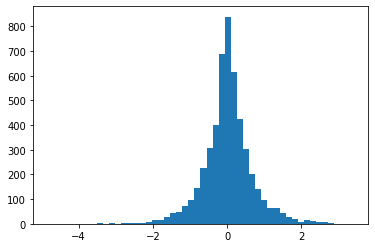

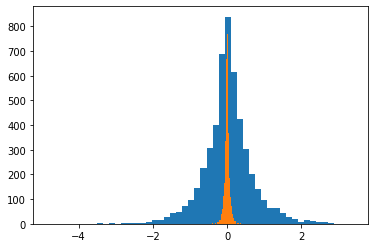

In [39]:
vol_model = time_varying_vol()

Q1 = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = vol_model)
error_Q1, price_Q1 = Q1.simulate_delta_varying_vol()
plt.figure(0)
plt.hist(error_Q1, bins = 50)

High_steps_Q1 = Hedger(S0, K, T, r, mu, n_sims, n_steps * 100, vol_model = vol_model)
error2, price2 = High_steps_Q1.simulate_delta_varying_vol()

plt.figure(1)
plt.hist(error_Q1, bins = 50)
plt.hist(error2, bins = 50)

In [40]:
assert_almost_equal(np.percentile(error_Q1, q = [2.5, 97.5]), np.array([-1.39609292,  1.46532121]))

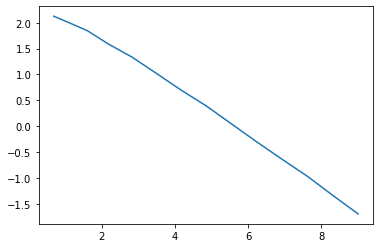

In [41]:
n_points = 14
n_steps_rme_testing = np.zeros(n_points)
rms_error = np.zeros(n_points)
for i in range(0, n_points):
    n_steps_rme_testing[i] = 2 ** i + 1
    dummy_hedger = Hedger(S0, K, T, r, mu, n_sims, int(n_steps_rme_testing[i]), vol_model = vol_model)
    error, price = dummy_hedger.simulate_delta_varying_vol()
    rms_error[i] = np.sqrt(np.mean(error ** 2))

ax = plt.gca()
ax.plot(np.log(n_steps_rme_testing), np.log(rms_error))

## Q2

In [42]:
Dummy = Hedger(S0, K, T, r, mu, n_sims, n_steps, vol_model = vol_model, simulation_end_time = T/2)

e, p = Dummy.simulate_delta_varying_vol()

(array([  1.,   3.,  10.,  15.,  41.,  72., 153., 279., 439., 648., 870.,
        835., 691., 436., 272., 135.,  65.,  20.,  10.,   5.]),
 array([-0.46057624, -0.41827499, -0.37597375, -0.33367251, -0.29137126,
        -0.24907002, -0.20676878, -0.16446753, -0.12216629, -0.07986505,
        -0.0375638 ,  0.00473744,  0.04703868,  0.08933993,  0.13164117,
         0.17394241,  0.21624366,  0.2585449 ,  0.30084614,  0.34314739,
         0.38544863]),
 <BarContainer object of 20 artists>)

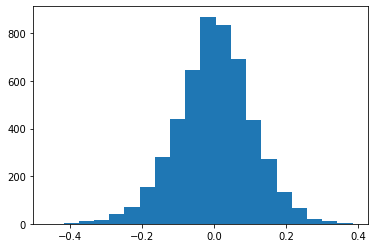

In [43]:
plt.hist(e, bins = 20)

In [44]:
Q2_Test = Hedger(S0, K, 0.3, r, mu, 1_000, 1_000, vol_model = vol_model, simulation_end_time = 0.15, constant_vol_assumption = True)
Q2_test_error, Q2_price_error = Q2_Test.simulate_delta_varying_vol()


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   2.,   1.,   7.,   7.,
         13., 650., 298.,   8.,   6.,   3.,   0.,   1.]),
 array([-5.30456258e-03, -5.08313609e-03, -4.86170961e-03, -4.64028313e-03,
        -4.41885665e-03, -4.19743017e-03, -3.97600369e-03, -3.75457721e-03,
        -3.53315073e-03, -3.31172424e-03, -3.09029776e-03, -2.86887128e-03,
        -2.64744480e-03, -2.42601832e-03, -2.20459184e-03, -1.98316536e-03,
        -1.76173888e-03, -1.54031240e-03, -1.31888591e-03, -1.09745943e-03,
        -8.76032952e-04, -6.54606471e-04, -4.33179990e-04, -2.11753508e-04,
         9.67297278e-06,  2.31099454e-04,  4.52525935e-04,  6.73952416e-04,
         8.95378897e-04,  1.11680538e-03,  1.33823186e-03]),
 <BarContainer object of 30 artists>)

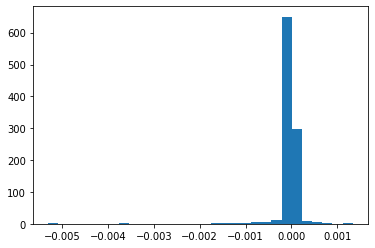

In [45]:
plt.hist(Q2_test_error, bins = 30)

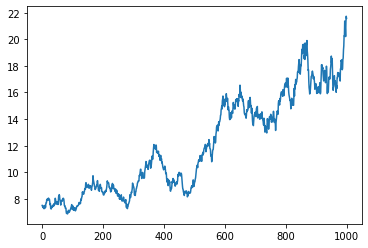

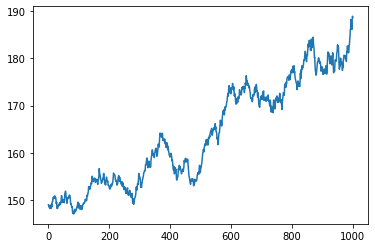

In [46]:
Q2 = Hedger(S0, K, T, r, mu, 1_000, 1_000, vol_model = vol_model, simulation_end_time = T/2, constant_vol_assumption = True)
error_Q2, price_Q2 = Q2.simulate_delta_varying_vol()



plt.figure(0)
plt.plot(Q2.portfolio[2, :])
plt.figure(1)
plt.plot(Q2.paths[2, :])


In [47]:
assert_almost_equal(np.percentile(error_Q2, q = [2.5, 97.5]), np.array([2.38401743, 4.37940813]))

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  2.,  3.,  4.,  2.,
         5.,  1.,  5.,  7.,  2.,  5.,  6.,  4.,  3., 13.,  9.,  5., 11.,
        16.,  7.,  7., 12.,  8., 17.,  9., 16., 12., 10., 11.,  6., 13.,
        15., 18., 15., 16., 16., 23., 23., 19., 19., 14., 32., 19., 31.,
        17., 22., 18., 22., 24., 29., 25., 25., 17., 26., 27., 22., 22.,
        16., 17., 21., 16., 21., 18., 24., 14., 15., 12.,  9.,  8.,  3.,
         4.,  2.,  4.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.46217267, 1.49506811, 1.52796355, 1.56085899, 1.59375444,
        1.62664988, 1.65954532, 1.69244076, 1.7253362 , 1.75823165,
        1.79112709, 1.82402253, 1.85691797, 1.88981341, 1.92270886,
        1.9556043 , 1.98849974, 2.02139518, 2.05429062, 2.08718607,
        2.12008151, 2.15297695, 2.18587239, 2.21876783, 2.25166328,
        2.28455872, 2.31745416, 2.3503496 , 2.38324504, 2.41614049,
        2.44903593, 2.4819

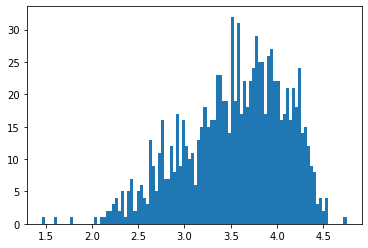

In [48]:
plt.hist(error_Q2, bins = 100)

## Q3 

In [36]:
Q3_vol_model = time_varying_vol()

def flat_vol(t):
    return sigma1 + sigma2

Q3_vol_model.time_varying_vol = flat_vol

assert(Q3_vol_model.time_varying_vol(1) == sigma1 + sigma2)

In [37]:
Q3 = Hedger(S0, K, T, r, mu, 1_000, 1_000, simulation_end_time = T, constant_vol_assumption = True)
error_Q2, price_Q2 = Q2.simulate_delta_varying_vol()

plt.figure(0)
plt.plot(Q2.portfolio[2, :])
plt.figure(1)
plt.plot(Q2.paths[2, :])

TypeError: Hedger.__init__() missing 1 required positional argument: 'vol_model'